In [126]:
from sklearn.linear_model import LogisticRegression
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
import yfinance as yf

pd.options.display.float_format = '{:.6f}'.format
plt.style.use("seaborn-v0_8")
from itertools import product

In [127]:
symbol = "EURUSD=X"
start = "2004-01-01"
end = "2020-01-01"
interval = '1d'

In [128]:
df = yf.download(symbol, start, end, interval=interval).Close.to_frame()
df.rename(columns={"Close": "price"}, inplace=True)
df['returns'] = np.log(df['price'].div(df['price'].shift(1)))
df

[*********************100%%**********************]  1 of 1 completed


,price,returns
Date,,
2004-01-01,1.258194,NaN
2004-01-02,1.258194,0.000000
2004-01-05,1.268698,0.008313
2004-01-06,1.272103,0.002681
2004-01-07,1.264095,-0.006315
...,...,...
2019-12-25,1.109016,-0.000333
2019-12-26,1.109545,0.000477
2019-12-27,1.110112,0.000510


In [129]:
df.dropna(inplace=True)

In [130]:
df['direction'] = np.sign(df.returns)

In [131]:
df.direction.value_counts()

direction
1.000000     2071
-1.000000    2054
0.000000       19
Name: count, dtype: int64

In [132]:
lags = 5

In [133]:
cols = []
for lag in range(1, lags+1):
    col = "lag{}".format(lag)
    df[col] = df.returns.shift(lag)
    cols.append(col)
df.dropna(inplace=True)
df

,price,returns,direction,lag1,lag2,lag3,lag4,lag5
Date,,,,,,,,
2004-01-09,1.285892,0.006549,1.000000,0.010547,-0.006315,0.002681,0.008313,0.000000
2004-01-12,1.274096,-0.009216,-1.000000,0.006549,0.010547,-0.006315,0.002681,0.008313
2004-01-13,1.278593,0.003523,1.000000,-0.009216,0.006549,0.010547,-0.006315,0.002681
2004-01-14,1.265102,-0.010607,-1.000000,0.003523,-0.009216,0.006549,0.010547,-0.006315
2004-01-15,1.260097,-0.003965,-1.000000,-0.010607,0.003523,-0.009216,0.006549,0.010547
...,...,...,...,...,...,...,...,...
2019-12-25,1.109016,-0.000333,-1.000000,0.001264,-0.004153,0.000901,-0.003184,0.001293
2019-12-26,1.109545,0.000477,1.000000,-0.000333,0.001264,-0.004153,0.000901,-0.003184
2019-12-27,1.110112,0.000510,1.000000,0.000477,-0.000333,0.001264,-0.004153,0.000901


In [134]:
lm = LogisticRegression(C=1e6, max_iter = 100000, multi_class = 'ovr')
lm.fit(df[cols], df.direction)

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1000000.0, max_iter=100000, multi_class='ovr')

In [135]:
df['prediction'] = lm.predict(df[cols])
df.prediction.value_counts()

prediction
1.000000     2172
-1.000000    1967
Name: count, dtype: int64

In [136]:
hits = np.sign(df.direction*df.prediction).value_counts()
hits

1.000000     2185
-1.000000    1936
0.000000       18
Name: count, dtype: int64

In [137]:
hit_ratio = hits[1.0] / sum(hits)
hit_ratio

np.float64(0.5279052911331239)

In [138]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=df.direction, y_pred=df.prediction)

0.5279052911331239

In [139]:
df['strategy'] = df.prediction * df.returns
df['creturns'] = df['returns'].cumsum().apply(np.exp)
df['cstrategy'] = df['strategy'].cumsum().apply(np.exp)
df

,price,returns,direction,lag1,lag2,lag3,lag4,lag5,prediction,strategy,creturns,cstrategy
Date,,,,,,,,,,,,
2004-01-09,1.285892,0.006549,1.000000,0.010547,-0.006315,0.002681,0.008313,0.000000,-1.000000,-0.006549,1.006571,0.993472
2004-01-12,1.274096,-0.009216,-1.000000,0.006549,0.010547,-0.006315,0.002681,0.008313,-1.000000,0.009216,0.997337,1.002670
2004-01-13,1.278593,0.003523,1.000000,-0.009216,0.006549,0.010547,-0.006315,0.002681,1.000000,0.003523,1.000857,1.006208
2004-01-14,1.265102,-0.010607,-1.000000,0.003523,-0.009216,0.006549,0.010547,-0.006315,-1.000000,0.010607,0.990297,1.016938
2004-01-15,1.260097,-0.003965,-1.000000,-0.010607,0.003523,-0.009216,0.006549,0.010547,1.000000,-0.003965,0.986378,1.012915
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,1.109016,-0.000333,-1.000000,0.001264,-0.004153,0.000901,-0.003184,0.001293,1.000000,-0.000333,0.868116,6.399307
2019-12-26,1.109545,0.000477,1.000000,-0.000333,0.001264,-0.004153,0.000901,-0.003184,1.000000,0.000477,0.868530,6.402361
2019-12-27,1.110112,0.000510,1.000000,0.000477,-0.000333,0.001264,-0.004153,0.000901,1.000000,0.000510,0.868973,6.405630


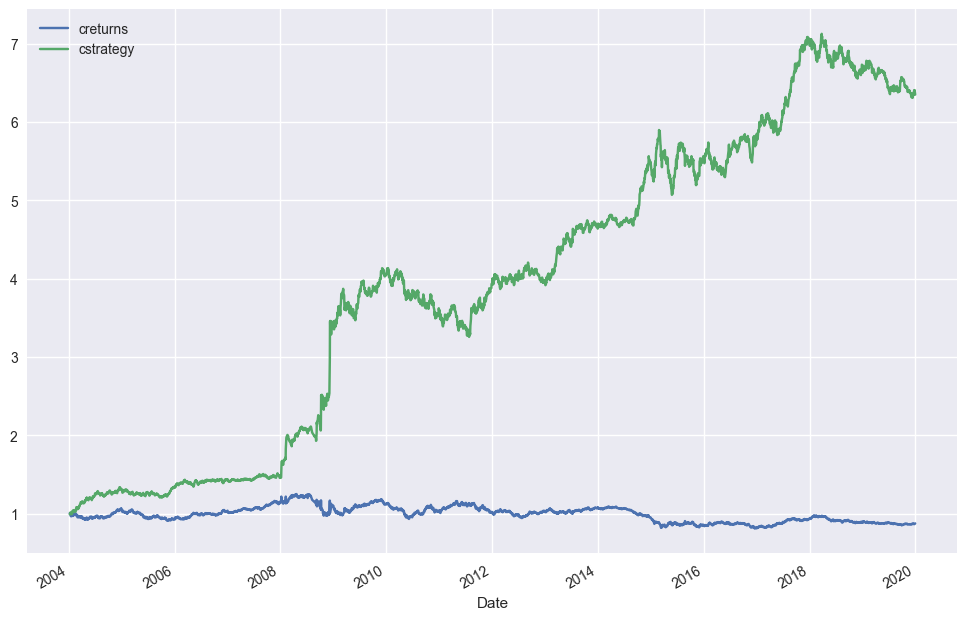

In [140]:
df[['creturns', 'cstrategy']].plot(figsize=(12,8))
plt.show()

In [141]:
df['trades'] = df.prediction.diff().fillna(0).abs()
df.trades.value_counts()

trades
0.000000    2423
2.000000    1716
Name: count, dtype: int64

In [142]:
symbol = "EURUSD=X"
start = "2022-01-01"
end = "2024-06-01"
interval = '1d'

In [143]:
testdf = yf.download(symbol, start, end, interval=interval).Close.to_frame()
testdf.rename(columns={"Close": "price"}, inplace=True)
testdf['returns'] = np.log(testdf['price'].div(testdf['price'].shift(1)))
testdf

[*********************100%%**********************]  1 of 1 completed


,price,returns
Date,,
2022-01-03,1.137346,NaN
2022-01-04,1.130224,-0.006281
2022-01-05,1.128363,-0.001649
2022-01-06,1.131350,0.002644
2022-01-07,1.129688,-0.001470
...,...,...
2024-05-27,1.084763,0.003227
2024-05-28,1.086189,0.001313
2024-05-29,1.085187,-0.000923


In [144]:
cols = []
for lag in range(1, lags+1):
    col = "lag{}".format(lag)
    testdf[col] = testdf.returns.shift(lag)
    cols.append(col)
testdf.dropna(inplace=True)
testdf

,price,returns,lag1,lag2,lag3,lag4,lag5
Date,,,,,,,
2022-01-11,1.133042,-0.002076,0.005040,-0.001470,0.002644,-0.001649,-0.006281
2022-01-12,1.136648,0.003178,-0.002076,0.005040,-0.001470,0.002644,-0.001649
2022-01-13,1.144165,0.006592,0.003178,-0.002076,0.005040,-0.001470,0.002644
2022-01-14,1.145712,0.001351,0.006592,0.003178,-0.002076,0.005040,-0.001470
2022-01-17,1.141070,-0.004059,0.001351,0.006592,0.003178,-0.002076,0.005040
...,...,...,...,...,...,...,...
2024-05-27,1.084763,0.003227,-0.001158,-0.002764,-0.000521,-0.001348,0.000707
2024-05-28,1.086189,0.001313,0.003227,-0.001158,-0.002764,-0.000521,-0.001348
2024-05-29,1.085187,-0.000923,0.001313,0.003227,-0.001158,-0.002764,-0.000521


In [152]:
testdf['prediction'] = lm.predict(testdf[cols])
testdf['direction'] = np.sign(testdf.returns)
testdf

,price,returns,lag1,lag2,lag3,lag4,lag5,prediction,strategy,creturns,cstrategy,direction
Date,,,,,,,,,,,,
2022-01-11,1.133042,-0.002076,0.005040,-0.001470,0.002644,-0.001649,-0.006281,-1.000000,0.002076,0.997926,1.002078,-1.000000
2022-01-12,1.136648,0.003178,-0.002076,0.005040,-0.001470,0.002644,-0.001649,1.000000,0.003178,1.001103,1.005267,1.000000
2022-01-13,1.144165,0.006592,0.003178,-0.002076,0.005040,-0.001470,0.002644,-1.000000,-0.006592,1.007723,0.998663,1.000000
2022-01-14,1.145712,0.001351,0.006592,0.003178,-0.002076,0.005040,-0.001470,-1.000000,-0.001351,1.009085,0.997314,1.000000
2022-01-17,1.141070,-0.004059,0.001351,0.006592,0.003178,-0.002076,0.005040,-1.000000,0.004059,1.004998,1.001371,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,1.084763,0.003227,-0.001158,-0.002764,-0.000521,-0.001348,0.000707,1.000000,0.003227,0.955405,0.819977,1.000000
2024-05-28,1.086189,0.001313,0.003227,-0.001158,-0.002764,-0.000521,-0.001348,-1.000000,-0.001313,0.956661,0.818901,1.000000
2024-05-29,1.085187,-0.000923,0.001313,0.003227,-0.001158,-0.002764,-0.000521,-1.000000,0.000923,0.955779,0.819657,-1.000000


In [147]:
testdf['strategy'] = testdf.prediction * testdf.returns
testdf['creturns'] = testdf['returns'].cumsum().apply(np.exp)
testdf['cstrategy'] = testdf['strategy'].cumsum().apply(np.exp)
testdf

,price,returns,lag1,lag2,lag3,lag4,lag5,prediction,strategy,creturns,cstrategy
Date,,,,,,,,,,,
2022-01-11,1.133042,-0.002076,0.005040,-0.001470,0.002644,-0.001649,-0.006281,-1.000000,0.002076,0.997926,1.002078
2022-01-12,1.136648,0.003178,-0.002076,0.005040,-0.001470,0.002644,-0.001649,1.000000,0.003178,1.001103,1.005267
2022-01-13,1.144165,0.006592,0.003178,-0.002076,0.005040,-0.001470,0.002644,-1.000000,-0.006592,1.007723,0.998663
2022-01-14,1.145712,0.001351,0.006592,0.003178,-0.002076,0.005040,-0.001470,-1.000000,-0.001351,1.009085,0.997314
2022-01-17,1.141070,-0.004059,0.001351,0.006592,0.003178,-0.002076,0.005040,-1.000000,0.004059,1.004998,1.001371
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,1.084763,0.003227,-0.001158,-0.002764,-0.000521,-0.001348,0.000707,1.000000,0.003227,0.955405,0.819977
2024-05-28,1.086189,0.001313,0.003227,-0.001158,-0.002764,-0.000521,-0.001348,-1.000000,-0.001313,0.956661,0.818901
2024-05-29,1.085187,-0.000923,0.001313,0.003227,-0.001158,-0.002764,-0.000521,-1.000000,0.000923,0.955779,0.819657


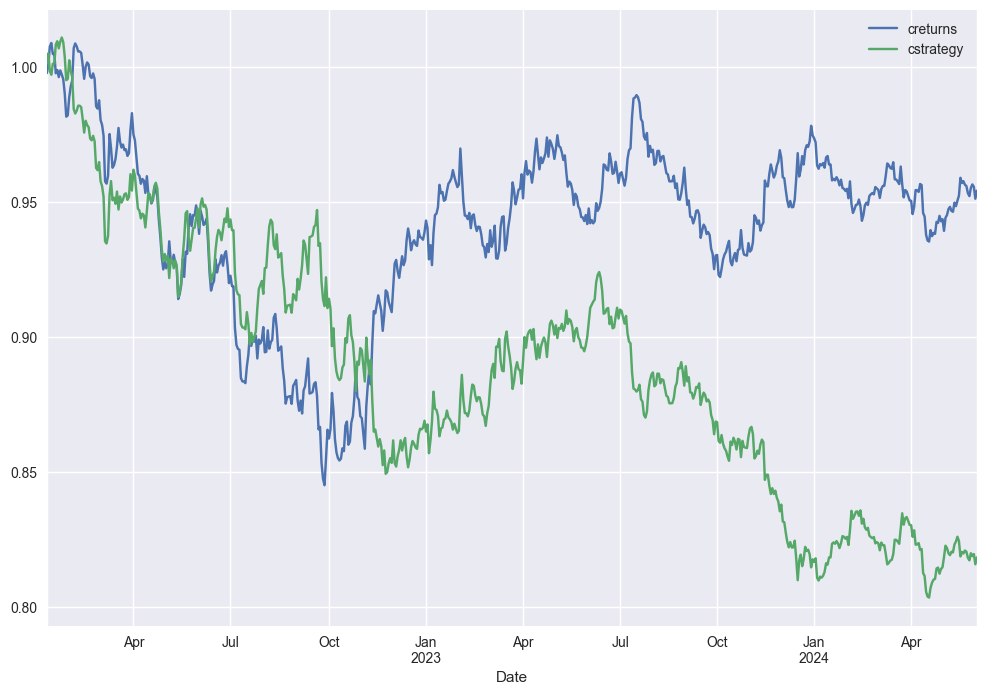

In [149]:
testdf[['creturns', 'cstrategy']].plot(figsize=(12,8))
plt.show()

In [154]:
hits = np.sign(testdf.direction*testdf.prediction).value_counts()
hits

direction
-1.000000    326
1.000000     297
0.000000       1
Name: count, dtype: int64